In [51]:
import pandas as pd
import re
import numpy as np
import nltk
import pickle 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from nltk.tokenize import sent_tokenize

In [52]:
df_data = pd.read_csv('data.csv', encoding='latin')
df_abuse = pd.read_csv('abusive.csv', encoding='latin')
df_alay = pd.read_csv('new_kamusalay.csv', names = ['Kata alay','Kata ganti'], encoding='latin')
df_stop = pd.read_csv('stopwordbahasa.csv', names = ['stopword'])

col_names = ['Text','Sentiment']
df_train = pd.read_csv('train_preprocess.tsv.txt', on_bad_lines = 'skip', names = col_names, sep = '\t') 

In [53]:
temp_df = df_data #Assign to a new variable for testing
temp_df1 = df_data #test variable

In [54]:
df_data.tail()

Tweet  HS  Abusive  \
13164  USER jangan asal ngomong ndasmu. congor lu yg ...   1        1   
13165                       USER Kasur mana enak kunyuk'   0        1   
13166  USER Hati hati bisu :( .g\n\nlagi bosan huft \...   0        0   
13167  USER USER USER USER Bom yang real mudah terdet...   0        0   
13168  USER Mana situ ngasih(": itu cuma foto ya kuti...   1        1   

       HS_Individual  HS_Group  HS_Religion  HS_Race  HS_Physical  HS_Gender  \
13164              1         0            0        0            1          0   
13165              0         0            0        0            0          0   
13166              0         0            0        0            0          0   
13167              0         0            0        0            0          0   
13168              1         0            0        0            0          0   

       HS_Other  HS_Weak  HS_Moderate  HS_Strong  
13164         0        1            0          0  
13165         0        0            0          0  
13166         0        0            0          0  
13167         0        0            0          0  
13168         1        1            0          0

In [55]:
temp_df.tail()

Tweet  HS  Abusive  \
13164  USER jangan asal ngomong ndasmu. congor lu yg ...   1        1   
13165                       USER Kasur mana enak kunyuk'   0        1   
13166  USER Hati hati bisu :( .g\n\nlagi bosan huft \...   0        0   
13167  USER USER USER USER Bom yang real mudah terdet...   0        0   
13168  USER Mana situ ngasih(": itu cuma foto ya kuti...   1        1   

       HS_Individual  HS_Group  HS_Religion  HS_Race  HS_Physical  HS_Gender  \
13164              1         0            0        0            1          0   
13165              0         0            0        0            0          0   
13166              0         0            0        0            0          0   
13167              0         0            0        0            0          0   
13168              1         0            0        0            0          0   

       HS_Other  HS_Weak  HS_Moderate  HS_Strong  
13164         0        1            0          0  
13165         0        0            0          0  
13166         0        0            0          0  
13167         0        0            0          0  
13168         1        1            0          0

In [56]:
df_stop

stopword
0        ada
1     adalah
2     adanya
3     adapun
4       agak
..       ...
753     wong
754    yaitu
755    yakin
756    yakni
757     yang

[758 rows x 1 columns]

In [57]:
temp_df.shape

(13169, 13)

In [58]:
temp_df.info() #no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


In [59]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       11000 non-null  object
 1   Sentiment  11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [60]:
def remove_chars(text):
    text = re.sub(r'[^a-zA-Z0-9]',' ', str(text)) #convert to string to be able to replace
    text = text.lower() #lowercase all text
    text = text.strip() #strip trailing or leading characters
    text = re.sub('\n', ' ', text) #remove \n
    text = re.sub('user',' ', text) #remove user
    text = re.sub('https\S+','',text) #remove links and whitespaces
    text = re.sub('(rt) | (RT)',' ',text) #remove RTs
    text = re.sub('  +',' ', text) #remove space lebih
    text = re.sub('USER',' ',text) #remove the word user
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split()) #remove hashtags, @, links
    text = re.sub('tweet',' ',text) #remove tweet
    text = re.sub('hs',' ',text) #remove hs
    text = re.sub('abusive',' ',text) #remove abusive
    text = re.sub('x[a-z0-9]{2}',' ',text) #remove emoticons
    text = re.sub(';',' ',text)
    text = re.sub(':',' ',text)
    return text

alay_dict = dict(zip(df_alay['Kata alay'], df_alay['Kata ganti']))

def clean_alay(text):
    return ' '.join([alay_dict[alay] if alay in alay_dict else alay for alay in text.split(' ')])

def clean_stop(text):
    text = ' '.join(['' if stop in df_stop.stopword.values else stop for stop in text.split(' ')])
    text = text.strip() #strip trailing or leading characters
    text = re.sub('  +',' ', text) #remove space lebih
    return text

#try removing early spaces
def clean_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

In [61]:
def full_clean(text):
    text = remove_chars(text)
    text = clean_alay(text)
    text = clean_stop(text)
    #text = clean_space(text)
    return text

In [62]:
neg = df_train.loc[df_train['Sentiment'] == 'negative'].Text.tolist()
neu = df_train.loc[df_train['Sentiment'] == 'neutral'].Text.tolist()
pos = df_train.loc[df_train['Sentiment'] == 'positive'].Text.tolist()

neg_label = df_train.loc[df_train['Sentiment'] == 'negative'].Sentiment.tolist()
neu_label = df_train.loc[df_train['Sentiment'] == 'neutral'].Sentiment.tolist()
pos_label = df_train.loc[df_train['Sentiment'] == 'positive'].Sentiment.tolist()

In [63]:
new_data = neg + neu + pos
labels = neg_label + neu_label + pos_label

print('pos: %s, neu: %s, neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(new_data))

pos: 6416, neu: 1148, neg: 3436
Total data: 11000


In [64]:
max_features = 100000
tokenizer = Tokenizer(num_words = max_features, split = ' ', lower = True)
tokenizer.fit_on_texts(new_data)
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print('tokenizer function is saved')

X = tokenizer.texts_to_sequences(new_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(X) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
    pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print('pad sequences function is saved')

tokenizer function is saved
pad sequences function is saved


In [65]:
Y =pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle','wb') as handle:
    pickle.dump(Y, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print('y_label is saved')

y_label is saved


In [66]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_test, X_train, y_test, y_train = train_test_split(X, Y, test_size = 0.2, random_state= 1, stratify=Y)

#Pake stratify untuk menyamakan proporsi test size dengan proporsi label data. 

In [67]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [68]:
#tambah parameter patience, walaupun perbandingan antar epoch kecil tapi tetep lanjut sesuai ankga yg kita set.

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(LSTM(units, dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
history = model.fit(X_train, y_train, epochs = 10, batch_size = 10, validation_data = (X_test, y_test), verbose = 1, callbacks = [es])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 96, 100)           10000000  
                                                                 
 lstm_8 (LSTM)               (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
220/220 [==============================] - 153s 580ms/step - loss: 0.6568 - accuracy: 0.7086 - val_loss: 0.5378 - val_accuracy: 0.7732
Epoch 2/10
220/220 [==============================] - 75s 339ms/step - loss: 0.3300 - accuracy: 0.8786 - val_loss: 0.4508 - val_accuracy: 0.8474
Epoch 3/10

In [69]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
print('Report: ')
print(matrix_test)

275/275 [==============================] - 9s 27ms/step
Report: 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      2749
           1       0.79      0.67      0.72       918
           2       0.86      0.92      0.89      5133

    accuracy                           0.84      8800
   macro avg       0.82      0.77      0.79      8800
weighted avg       0.83      0.84      0.83      8800



In [70]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
#tambah parameter patience, walaupun perbandingan antar epoch kecil tapi tetep lanjut sesuai ankga yg kita set.

kf = KFold(n_splits = 5, random_state= 42, shuffle = True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start = 1):

    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
    model.add(LSTM(units, dropout = 0.2))
    model.add(Dense(3, activation = 'softmax'))

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 3)
    history = model.fit(X_train, y_train, epochs = 10, batch_size = 10, validation_data =(X_test, y_test), verbose = 0, callbacks = [es])

    predictions = model.predict(X_test)

    y_pred = predictions

    #accuracy for current fold
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    print('Training ke-', iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('------------------------------------------------------')

    accuracies.append(accuracy)

#average accuracy of folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print('rata-rata accuracy: ', average_accuracy)


275/275 [==============================] - 9s 28ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2749
           1       0.78      0.61      0.68       918
           2       0.87      0.90      0.89      5133

    accuracy                           0.83      8800
   macro avg       0.80      0.76      0.78      8800
weighted avg       0.83      0.83      0.83      8800

------------------------------------------------------
275/275 [==============================] - 7s 24ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.86      0.51      0.64      2749
           1       0.55      0.81      0.66       918
           2       0.82      0.93      0.88      5133

    accuracy                           0.79      8800
   macro avg       0.74      0.75      0.72      8800
weighted avg       0.81      0.79      0.78      8800

-----------------------------------------

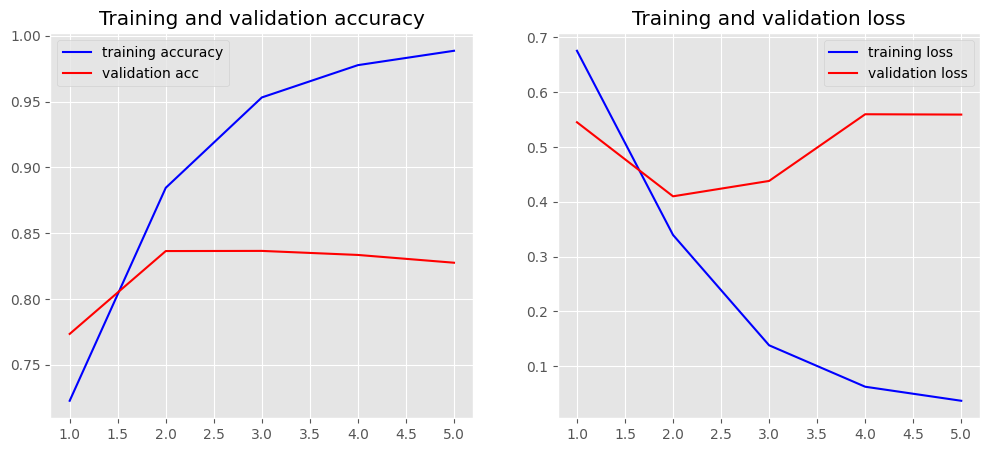

In [71]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize = (12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label = 'training accuracy')
    plt.plot(x, val_acc, 'r', label = 'validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label = 'training loss')
    plt.plot(x, val_loss, 'r', label = 'validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
%matplotlib inline
plot_history(history)

In [72]:
model.save('model_sentiment.h5')
print('model saved')

model saved
